# Predict : Sendy logistic challange 
The purpose of this notebook is to create predictive model that predict the estimated time of arrival for motorbike deliveries in Nairobi 


Imports 





In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import array
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold 
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [66]:
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import math
import random
from sklearn.linear_model import *
from sklearn import *

In [67]:
train_df = pd.read_csv('Train.csv') # read files
test_df = pd.read_csv('Test.csv')
riders_df = pd.read_csv('Riders.csv')

In [68]:
train_df.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [69]:
train_df = train_df.merge(riders_df,on='Rider Id') # merge datasets

In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 33 columns):
Order No                                     21201 non-null object
User Id                                      21201 non-null object
Vehicle Type                                 21201 non-null object
Platform Type                                21201 non-null int64
Personal or Business                         21201 non-null object
Placement - Day of Month                     21201 non-null int64
Placement - Weekday (Mo = 1)                 21201 non-null int64
Placement - Time                             21201 non-null object
Confirmation - Day of Month                  21201 non-null int64
Confirmation - Weekday (Mo = 1)              21201 non-null int64
Confirmation - Time                          21201 non-null object
Arrival at Pickup - Day of Month             21201 non-null int64
Arrival at Pickup - Weekday (Mo = 1)         21201 non-null int64
Arrival at Pickup - Time   

In [71]:
train_df.isna().sum() #looking for missing values

Order No                                         0
User Id                                          0
Vehicle Type                                     0
Platform Type                                    0
Personal or Business                             0
Placement - Day of Month                         0
Placement - Weekday (Mo = 1)                     0
Placement - Time                                 0
Confirmation - Day of Month                      0
Confirmation - Weekday (Mo = 1)                  0
Confirmation - Time                              0
Arrival at Pickup - Day of Month                 0
Arrival at Pickup - Weekday (Mo = 1)             0
Arrival at Pickup - Time                         0
Pickup - Day of Month                            0
Pickup - Weekday (Mo = 1)                        0
Pickup - Time                                    0
Arrival at Destination - Day of Month            0
Arrival at Destination - Weekday (Mo = 1)        0
Arrival at Destination - Time  

In [72]:
def nul_percentage(df): # percentage of missing values
    return df.isna().mean().round(4)*100


In [73]:
nul_percentage(train_df)

Order No                                      0.00
User Id                                       0.00
Vehicle Type                                  0.00
Platform Type                                 0.00
Personal or Business                          0.00
Placement - Day of Month                      0.00
Placement - Weekday (Mo = 1)                  0.00
Placement - Time                              0.00
Confirmation - Day of Month                   0.00
Confirmation - Weekday (Mo = 1)               0.00
Confirmation - Time                           0.00
Arrival at Pickup - Day of Month              0.00
Arrival at Pickup - Weekday (Mo = 1)          0.00
Arrival at Pickup - Time                      0.00
Pickup - Day of Month                         0.00
Pickup - Weekday (Mo = 1)                     0.00
Pickup - Time                                 0.00
Arrival at Destination - Day of Month         0.00
Arrival at Destination - Weekday (Mo = 1)     0.00
Arrival at Destination - Time  

In [74]:
train_df['Temperature'] = train_df['Temperature'].fillna(round(train_df['Temperature'].mean(),1)) # fill na with mean
train_df.drop(['Precipitation in millimeters'], axis = 1, inplace = True) #drop column becase mean is more than 90%

In [75]:
train_new = train_df.copy()

In [76]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 32 columns):
Order No                                     21201 non-null object
User Id                                      21201 non-null object
Vehicle Type                                 21201 non-null object
Platform Type                                21201 non-null int64
Personal or Business                         21201 non-null object
Placement - Day of Month                     21201 non-null int64
Placement - Weekday (Mo = 1)                 21201 non-null int64
Placement - Time                             21201 non-null object
Confirmation - Day of Month                  21201 non-null int64
Confirmation - Weekday (Mo = 1)              21201 non-null int64
Confirmation - Time                          21201 non-null object
Arrival at Pickup - Day of Month             21201 non-null int64
Arrival at Pickup - Weekday (Mo = 1)         21201 non-null int64
Arrival at Pickup - Time   

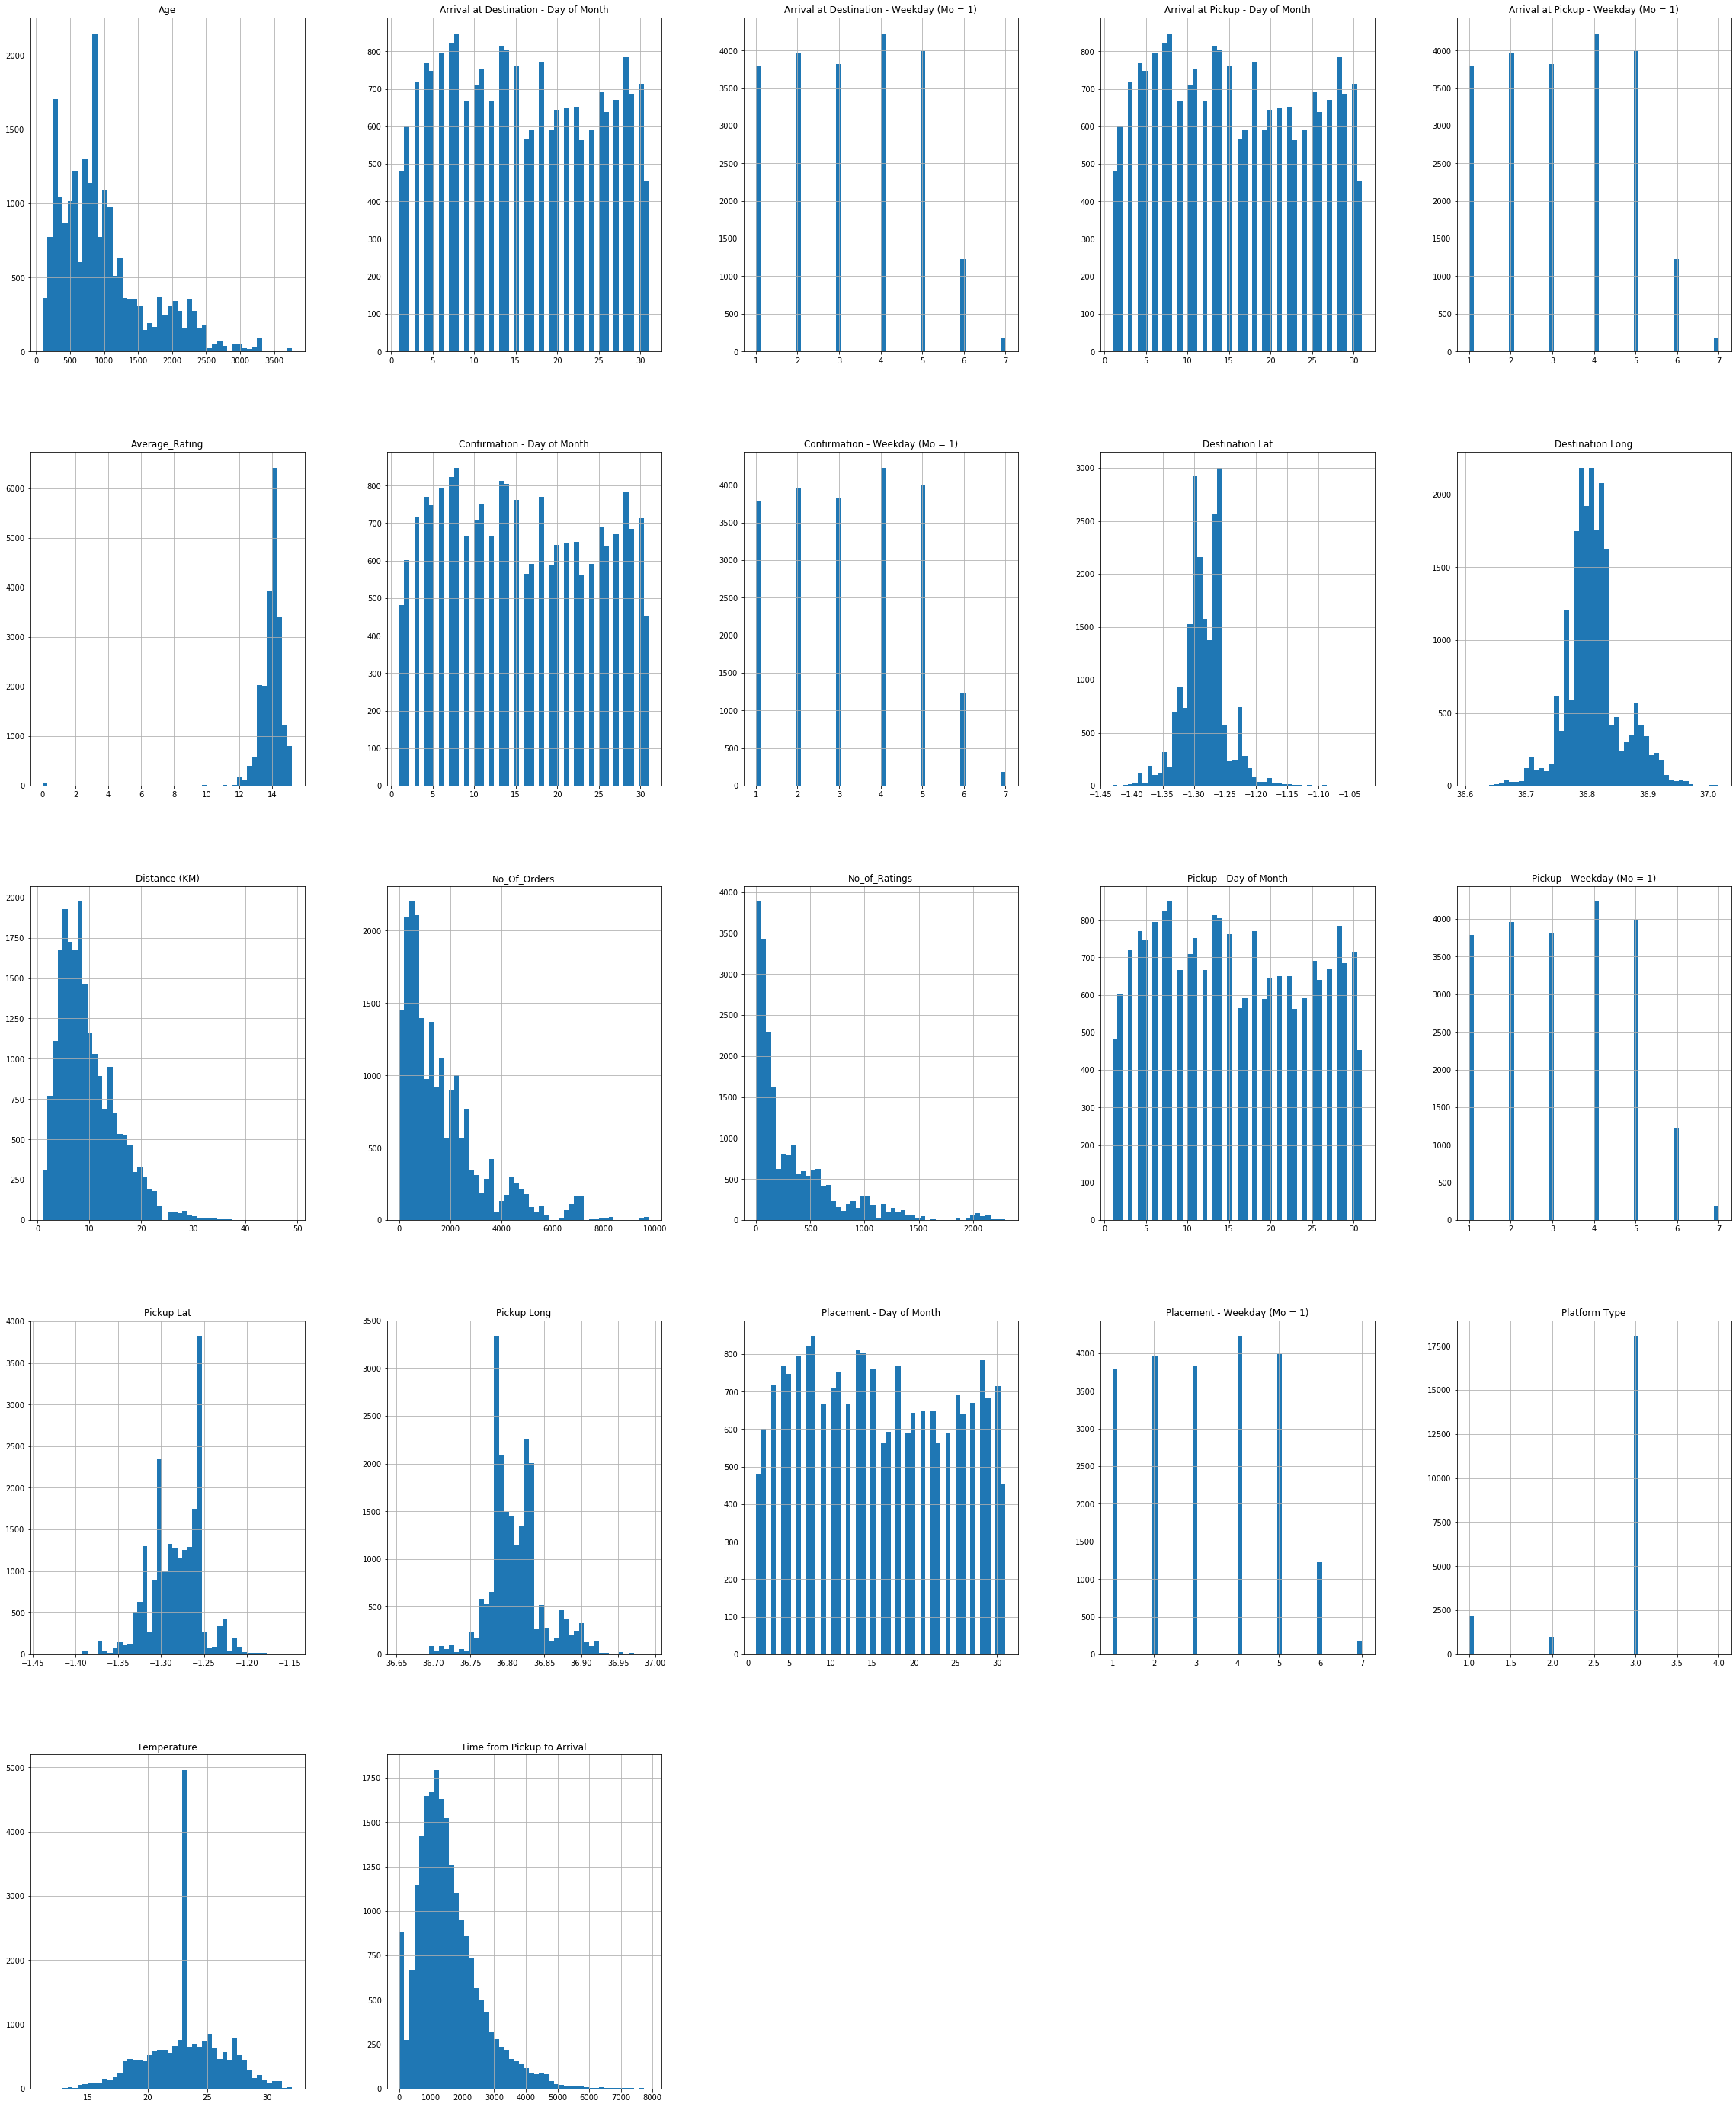

In [77]:
train_df.hist(bins=50 , figsize=(40,50)) 
plt.show()

In [78]:
print(train_df.corr())
sns.heatmap(data=train_df)

                                           Platform Type  \
Platform Type                                   1.000000   
Placement - Day of Month                        0.012764   
Placement - Weekday (Mo = 1)                   -0.058038   
Confirmation - Day of Month                     0.012770   
Confirmation - Weekday (Mo = 1)                -0.058005   
Arrival at Pickup - Day of Month                0.012770   
Arrival at Pickup - Weekday (Mo = 1)           -0.058005   
Pickup - Day of Month                           0.012770   
Pickup - Weekday (Mo = 1)                      -0.058005   
Arrival at Destination - Day of Month           0.012770   
Arrival at Destination - Weekday (Mo = 1)      -0.058005   
Distance (KM)                                   0.005528   
Temperature                                     0.212042   
Pickup Lat                                     -0.002742   
Pickup Long                                     0.021327   
Destination Lat                         

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [79]:
train_df.drop(['Placement - Weekday (Mo = 1)'],axis=1,inplace=True) # drop columns 

In [80]:
train_df.drop(['Confirmation - Day of Month'],axis=1,inplace=True)

In [81]:
train_df.drop(['Confirmation - Weekday (Mo = 1)'],axis=1,inplace=True)

In [82]:
train_df.drop(['Arrival at Pickup - Day of Month'],axis=1,inplace=True)

In [83]:
train_df.drop(['Arrival at Pickup - Weekday (Mo = 1)'],axis=1,inplace=True)

In [84]:
train_df.drop(['Pickup - Day of Month'], axis=1,inplace=True)

In [85]:
train_df.drop(['Pickup - Weekday (Mo = 1)'],axis=1,inplace=True)

In [86]:
train_df.drop(['Arrival at Destination - Day of Month'],axis=1,inplace=True)

In [87]:
train_df.drop(['Arrival at Destination - Weekday (Mo = 1)'],axis=1,inplace=True)

In [88]:
train_df.drop(['Order No'],axis=1,inplace=True)

In [89]:
train_df.drop(['Vehicle Type'],axis=1,inplace=True)

In [90]:
train_df.drop(['User Id'],axis=1, inplace=True)

In [91]:
train_df.drop(['Arrival at Pickup - Time'],axis=1, inplace=True)

In [92]:
train_df.drop(['Platform Type'],axis=1,inplace=True)

In [93]:
def word_split(df): # split words in column
    id_num = df['Rider Id'].astype(str)
    new_id = df['Rider Id'].str.split('_')
    id_split = new_id.apply(lambda x : x[-1])
    df['Rider Id'] = id_split.astype(int)
    return df

In [94]:
 word_split(train_df)

,Personal or Business,Placement - Day of Month,Placement - Time,Confirmation - Time,Pickup - Time,Arrival at Destination - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Business,9,9:35:46 AM,9:40:10 AM,10:27:30 AM,10:39:55 AM,4,20.4,-1.317755,36.830370,-1.300406,36.829741,432,745,1637,1309,13.8,549
1,Personal,18,3:41:17 PM,3:41:30 PM,4:13:37 PM,5:01:43 PM,20,24.5,-1.326774,36.787807,-1.356237,36.904295,432,2886,1637,1309,13.8,549
2,Business,31,12:51:41 PM,1:12:49 PM,1:33:08 PM,2:16:43 PM,6,24.7,-1.255189,36.782203,-1.273412,36.818206,432,2615,1637,1309,13.8,549
3,Personal,2,7:12:10 AM,7:12:29 AM,7:38:46 AM,8:28:32 AM,18,15.2,-1.290315,36.757377,-1.223520,36.802061,432,2986,1637,1309,13.8,549
4,Personal,22,10:40:58 AM,10:42:24 AM,10:59:40 AM,11:26:22 AM,7,19.2,-1.273524,36.799220,-1.300431,36.752427,432,1602,1637,1309,13.8,549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21196,Business,13,11:09:37 AM,11:32:18 AM,11:52:48 AM,12:08:07 PM,3,22.2,-1.265003,36.812624,-1.265432,36.795034,528,919,5770,1793,14.2,2205
21197,Personal,21,4:33:17 PM,4:47:27 PM,5:10:53 PM,5:49:44 PM,6,19.9,-1.269609,36.825741,-1.278067,36.783487,638,2331,102,873,13.7,32
21198,Business,10,5:00:40 PM,5:11:21 PM,6:07:17 PM,6:47:35 PM,7,19.0,-1.250823,36.789526,-1.285850,36.830629,773,2418,5,105,0.0,0
21199,Business,29,2:31:55 PM,2:32:43 PM,2:48:23 PM,3:00:20 PM,2,27.0,-1.291787,36.787267,-1.298575,36.808800,860,717,5,448,15.0,2


In [95]:
def convert_time(df): # convert time object to time delta
    time_colum = [col for col in df if col.endswith('Time')]
    convert = df.loc[:,time_colum].apply(pd.to_datetime)
    df[time_colum] = convert - pd.Timestamp('today').normalize()
    return df

In [96]:
convert_time(train_df) 

,Personal or Business,Placement - Day of Month,Placement - Time,Confirmation - Time,Pickup - Time,Arrival at Destination - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Business,9,09:35:46,09:40:10,10:27:30,10:39:55,4,20.4,-1.317755,36.830370,-1.300406,36.829741,432,745,1637,1309,13.8,549
1,Personal,18,15:41:17,15:41:30,16:13:37,17:01:43,20,24.5,-1.326774,36.787807,-1.356237,36.904295,432,2886,1637,1309,13.8,549
2,Business,31,12:51:41,13:12:49,13:33:08,14:16:43,6,24.7,-1.255189,36.782203,-1.273412,36.818206,432,2615,1637,1309,13.8,549
3,Personal,2,07:12:10,07:12:29,07:38:46,08:28:32,18,15.2,-1.290315,36.757377,-1.223520,36.802061,432,2986,1637,1309,13.8,549
4,Personal,22,10:40:58,10:42:24,10:59:40,11:26:22,7,19.2,-1.273524,36.799220,-1.300431,36.752427,432,1602,1637,1309,13.8,549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21196,Business,13,11:09:37,11:32:18,11:52:48,12:08:07,3,22.2,-1.265003,36.812624,-1.265432,36.795034,528,919,5770,1793,14.2,2205
21197,Personal,21,16:33:17,16:47:27,17:10:53,17:49:44,6,19.9,-1.269609,36.825741,-1.278067,36.783487,638,2331,102,873,13.7,32
21198,Business,10,17:00:40,17:11:21,18:07:17,18:47:35,7,19.0,-1.250823,36.789526,-1.285850,36.830629,773,2418,5,105,0.0,0
21199,Business,29,14:31:55,14:32:43,14:48:23,15:00:20,2,27.0,-1.291787,36.787267,-1.298575,36.808800,860,717,5,448,15.0,2


In [97]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 18 columns):
Personal or Business             21201 non-null object
Placement - Day of Month         21201 non-null int64
Placement - Time                 21201 non-null timedelta64[ns]
Confirmation - Time              21201 non-null timedelta64[ns]
Pickup - Time                    21201 non-null timedelta64[ns]
Arrival at Destination - Time    21201 non-null timedelta64[ns]
Distance (KM)                    21201 non-null int64
Temperature                      21201 non-null float64
Pickup Lat                       21201 non-null float64
Pickup Long                      21201 non-null float64
Destination Lat                  21201 non-null float64
Destination Long                 21201 non-null float64
Rider Id                         21201 non-null int32
Time from Pickup to Arrival      21201 non-null int64
No_Of_Orders                     21201 non-null int64
Age                           

In [98]:
train_df['Lead_Time'] = train_df['Confirmation - Time'] - train_df['Placement - Time']
train_df['Time_from_con_to_pick'] = train_df['Pickup - Time'] - train_df['Confirmation - Time']


In [99]:
train_df['Confirmation - Time'] = train_df['Confirmation - Time'] / np.timedelta64(1,'s')
train_df['Placement - Time'] = train_df['Placement - Time'] / np.timedelta64(1,'s')
train_df['Pickup - Time'] = train_df['Pickup - Time'] / np.timedelta64(1,'s')
train_df['Lead_Time'] = train_df['Lead_Time'] / np.timedelta64(1, 's')
train_df['Time_from_con_to_pick']=train_df['Time_from_con_to_pick'] / np.timedelta64(1, 's')

In [100]:
train_df.drop(['Arrival at Destination - Time'],axis=1,inplace=True)

In [101]:
train_df = pd.get_dummies(train_df, columns=['Personal or Business'], drop_first=True)

In [102]:
train_df.head()

,Placement - Day of Month,Placement - Time,Confirmation - Time,Pickup - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Lead_Time,Time_from_con_to_pick,Personal or Business_Personal
0,9,34546.0,34810.0,37650.0,4,20.4,-1.317755,36.830370,-1.300406,36.829741,432,745,1637,1309,13.8,549,264.0,2840.0,0
1,18,56477.0,56490.0,58417.0,20,24.5,-1.326774,36.787807,-1.356237,36.904295,432,2886,1637,1309,13.8,549,13.0,1927.0,1
2,31,46301.0,47569.0,48788.0,6,24.7,-1.255189,36.782203,-1.273412,36.818206,432,2615,1637,1309,13.8,549,1268.0,1219.0,0
3,2,25930.0,25949.0,27526.0,18,15.2,-1.290315,36.757377,-1.223520,36.802061,432,2986,1637,1309,13.8,549,19.0,1577.0,1
4,22,38458.0,38544.0,39580.0,7,19.2,-1.273524,36.799220,-1.300431,36.752427,432,1602,1637,1309,13.8,549,86.0,1036.0,1


In [103]:
train_df.drop(['Rider Id'],axis=1,inplace=True)

In [104]:
train_new = train_df.copy()

In [105]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 18 columns):
Placement - Day of Month         21201 non-null int64
Placement - Time                 21201 non-null float64
Confirmation - Time              21201 non-null float64
Pickup - Time                    21201 non-null float64
Distance (KM)                    21201 non-null int64
Temperature                      21201 non-null float64
Pickup Lat                       21201 non-null float64
Pickup Long                      21201 non-null float64
Destination Lat                  21201 non-null float64
Destination Long                 21201 non-null float64
Time from Pickup to Arrival      21201 non-null int64
No_Of_Orders                     21201 non-null int64
Age                              21201 non-null int64
Average_Rating                   21201 non-null float64
No_of_Ratings                    21201 non-null int64
Lead_Time                        21201 non-null float64
Time_fr

In [106]:
X = train_df.drop(['Time from Pickup to Arrival'],axis=1)
y = train_df['Time from Pickup to Arrival']

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [107]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(0)

C:\Users\Private\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,4.0,Placement - Day of Month
1,inf,Placement - Time
2,inf,Confirmation - Time
3,inf,Pickup - Time
4,4.0,Distance (KM)
5,65.0,Temperature
6,1887.0,Pickup Lat
7,454602.0,Pickup Long
8,1379.0,Destination Lat
9,445798.0,Destination Long


In [108]:
train_df.drop(['Temperature'],axis=1,inplace=True)

In [109]:
train_df.drop(['Pickup Lat'],axis=1,inplace=True)

In [110]:
train_df.drop(['Pickup Long'],axis=1,inplace=True)

In [111]:
train_df.drop(['Destination Lat'],axis=1,inplace=True)

In [112]:
train_df.drop(['Destination Long'],axis=1,inplace=True)

In [113]:
train_df.drop(['Average_Rating'],axis=1,inplace=True)

In [114]:
rr = Ridge()
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=10)
rr.fit(X_train,y_train)
preds = rr.predict(X_test)

In [115]:
def rmse(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

In [116]:
rmse(y_test,preds)

779.4836108866247

In [117]:
from sklearn.neighbors import KNeighborsClassifier
KNeighborsClassifier = KNeighborsClassifier(n_neighbors=3)
KNeighborsClassifier.fit(X_train,y_train)
model = KNeighborsClassifier.predict(X_test)

In [118]:
rmse(y_test,model)

1306.9522809040295

In [119]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_m = lr.predict(X_test)

In [120]:
rmse(y_test,lr_m)

779.4625820057212

In [121]:
las = Lasso(alpha=0.01)
las.fit(X_train,y_train)
las_m = las.predict(X_test)

C:\Users\Private\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1344681297.3567257, tolerance: 1665829.0467311088
  positive)


In [122]:
rmse(y_test,las_m)

779.4737564416541

In [123]:
from sklearn.pipeline import Pipeline

In [124]:
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train,y_train)
rf = model.predict(X_test)

In [125]:
rmse(y_test,rf)

758.0604322929863

In [55]:
score = cross_val_score(model,X,y,cv=10)

In [56]:
score

array([0.39536317, 0.39460014, 0.37502716, 0.3125219 , 0.41589579,
       0.37858147, 0.3505663 , 0.36697287, 0.35257099, 0.38481685])

In [57]:
score.mean()

0.37269166306020296

# Do the same for test split

In [156]:
old_test = test_df.copy()

In [157]:
old_test.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,...,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,...,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,...,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,...,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,...,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858


In [158]:
old_test = old_test.merge(riders_df,on = 'Rider Id')

In [159]:
test_df = test_df.merge(riders_df,on='Rider Id')

In [160]:
test_df['Temperature'] = test_df['Temperature'].fillna(round(test_df['Temperature'].mean(),1))
test_df.drop(['Precipitation in millimeters'], axis = 1, inplace = True)

In [161]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7068 entries, 0 to 7067
Data columns (total 28 columns):
Order No                                7068 non-null object
User Id                                 7068 non-null object
Vehicle Type                            7068 non-null object
Platform Type                           7068 non-null int64
Personal or Business                    7068 non-null object
Placement - Day of Month                7068 non-null int64
Placement - Weekday (Mo = 1)            7068 non-null int64
Placement - Time                        7068 non-null object
Confirmation - Day of Month             7068 non-null int64
Confirmation - Weekday (Mo = 1)         7068 non-null int64
Confirmation - Time                     7068 non-null object
Arrival at Pickup - Day of Month        7068 non-null int64
Arrival at Pickup - Weekday (Mo = 1)    7068 non-null int64
Arrival at Pickup - Time                7068 non-null object
Pickup - Day of Month                   7068 n

In [162]:
test_df = test_df.drop(['Order No','User Id','Vehicle Type','Placement - Weekday (Mo = 1)','Confirmation - Day of Month','Confirmation - Weekday (Mo = 1)','Arrival at Pickup - Day of Month','Arrival at Pickup - Time','Pickup - Weekday (Mo = 1)'], axis=1)

In [163]:
test_df = test_df.drop(['Arrival at Pickup - Weekday (Mo = 1)','Pickup - Day of Month'], axis=1)
test_df.drop(['Platform Type'],axis=1,inplace=True)


In [164]:
test_df.head()

,Personal or Business,Placement - Day of Month,Placement - Time,Confirmation - Time,Pickup - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Business,27,4:44:10 PM,4:44:29 PM,5:06:47 PM,8,23.2,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192,439,1511,13.3,171
1,Personal,26,2:43:21 PM,2:47:16 PM,3:17:48 PM,19,23.2,-1.312745,36.875715,-1.288435,36.760677,Rider_Id_192,439,1511,13.3,171
2,Business,29,11:55:05 AM,11:58:12 AM,12:28:54 PM,9,19.7,-1.255189,36.782203,-1.293393,36.790237,Rider_Id_192,439,1511,13.3,171
3,Business,2,9:23:21 AM,9:23:44 AM,10:05:31 AM,15,16.4,-1.310451,36.868724,-1.259542,36.787118,Rider_Id_192,439,1511,13.3,171
4,Business,14,12:55:59 PM,1:22:44 PM,1:51:49 PM,15,21.3,-1.333275,36.870815,-1.255189,36.782203,Rider_Id_192,439,1511,13.3,171


In [165]:
word_split(test_df)

,Personal or Business,Placement - Day of Month,Placement - Time,Confirmation - Time,Pickup - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Business,27,4:44:10 PM,4:44:29 PM,5:06:47 PM,8,23.2,-1.333275,36.870815,-1.305249,36.822390,192,439,1511,13.3,171
1,Personal,26,2:43:21 PM,2:47:16 PM,3:17:48 PM,19,23.2,-1.312745,36.875715,-1.288435,36.760677,192,439,1511,13.3,171
2,Business,29,11:55:05 AM,11:58:12 AM,12:28:54 PM,9,19.7,-1.255189,36.782203,-1.293393,36.790237,192,439,1511,13.3,171
3,Business,2,9:23:21 AM,9:23:44 AM,10:05:31 AM,15,16.4,-1.310451,36.868724,-1.259542,36.787118,192,439,1511,13.3,171
4,Business,14,12:55:59 PM,1:22:44 PM,1:51:49 PM,15,21.3,-1.333275,36.870815,-1.255189,36.782203,192,439,1511,13.3,171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7063,Business,8,12:56:22 PM,1:43:10 PM,2:46:12 PM,8,27.1,-1.300921,36.828195,-1.272807,36.796236,738,2849,2506,14.2,427
7064,Business,9,3:08:38 PM,3:17:47 PM,3:38:22 PM,24,25.1,-1.316959,36.700003,-1.276574,36.851365,443,3504,2234,14.6,1086
7065,Business,31,1:25:34 PM,1:32:50 PM,1:42:45 PM,11,24.9,-1.303596,36.778378,-1.330611,36.848052,176,417,136,12.8,34
7066,Business,11,8:55:12 AM,8:55:46 AM,9:38:19 AM,19,20.9,-1.300921,36.828195,-1.319862,36.711032,181,34,291,15.0,5


In [166]:
convert_time(test_df)

,Personal or Business,Placement - Day of Month,Placement - Time,Confirmation - Time,Pickup - Time,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Business,27,16:44:10,16:44:29,17:06:47,8,23.2,-1.333275,36.870815,-1.305249,36.822390,192,439,1511,13.3,171
1,Personal,26,14:43:21,14:47:16,15:17:48,19,23.2,-1.312745,36.875715,-1.288435,36.760677,192,439,1511,13.3,171
2,Business,29,11:55:05,11:58:12,12:28:54,9,19.7,-1.255189,36.782203,-1.293393,36.790237,192,439,1511,13.3,171
3,Business,2,09:23:21,09:23:44,10:05:31,15,16.4,-1.310451,36.868724,-1.259542,36.787118,192,439,1511,13.3,171
4,Business,14,12:55:59,13:22:44,13:51:49,15,21.3,-1.333275,36.870815,-1.255189,36.782203,192,439,1511,13.3,171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7063,Business,8,12:56:22,13:43:10,14:46:12,8,27.1,-1.300921,36.828195,-1.272807,36.796236,738,2849,2506,14.2,427
7064,Business,9,15:08:38,15:17:47,15:38:22,24,25.1,-1.316959,36.700003,-1.276574,36.851365,443,3504,2234,14.6,1086
7065,Business,31,13:25:34,13:32:50,13:42:45,11,24.9,-1.303596,36.778378,-1.330611,36.848052,176,417,136,12.8,34
7066,Business,11,08:55:12,08:55:46,09:38:19,19,20.9,-1.300921,36.828195,-1.319862,36.711032,181,34,291,15.0,5


In [167]:
test_df['Lead_Time'] = test_df['Confirmation - Time'] - test_df['Placement - Time']
test_df['Time_from_con_to_pick'] = test_df['Pickup - Time'] - test_df['Confirmation - Time']

In [168]:
test_df['Confirmation - Time'] = test_df['Confirmation - Time'] / np.timedelta64(1,'s')
test_df['Placement - Time'] = test_df['Placement - Time'] / np.timedelta64(1,'s')
test_df['Pickup - Time'] = test_df['Pickup - Time'] / np.timedelta64(1,'s')
test_df['Lead_Time'] = test_df['Lead_Time'] / np.timedelta64(1, 's')
test_df['Time_from_con_to_pick']=test_df['Time_from_con_to_pick'] / np.timedelta64(1, 's')

In [169]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7068 entries, 0 to 7067
Data columns (total 18 columns):
Personal or Business        7068 non-null object
Placement - Day of Month    7068 non-null int64
Placement - Time            7068 non-null float64
Confirmation - Time         7068 non-null float64
Pickup - Time               7068 non-null float64
Distance (KM)               7068 non-null int64
Temperature                 7068 non-null float64
Pickup Lat                  7068 non-null float64
Pickup Long                 7068 non-null float64
Destination Lat             7068 non-null float64
Destination Long            7068 non-null float64
Rider Id                    7068 non-null int32
No_Of_Orders                7068 non-null int64
Age                         7068 non-null int64
Average_Rating              7068 non-null float64
No_of_Ratings               7068 non-null int64
Lead_Time                   7068 non-null float64
Time_from_con_to_pick       7068 non-null float64
dtypes

In [170]:
test_df = pd.get_dummies(test_df, columns=['Personal or Business'], drop_first=True)

In [171]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7068 entries, 0 to 7067
Data columns (total 18 columns):
Placement - Day of Month         7068 non-null int64
Placement - Time                 7068 non-null float64
Confirmation - Time              7068 non-null float64
Pickup - Time                    7068 non-null float64
Distance (KM)                    7068 non-null int64
Temperature                      7068 non-null float64
Pickup Lat                       7068 non-null float64
Pickup Long                      7068 non-null float64
Destination Lat                  7068 non-null float64
Destination Long                 7068 non-null float64
Rider Id                         7068 non-null int32
No_Of_Orders                     7068 non-null int64
Age                              7068 non-null int64
Average_Rating                   7068 non-null float64
No_of_Ratings                    7068 non-null int64
Lead_Time                        7068 non-null float64
Time_from_con_to_pick    

In [172]:
test_df.drop(['Rider Id'],axis=1,inplace=True)

In [173]:
old_test.columns = [col.replace(' ','_') for col in old_test.columns]

In [185]:
x_test = test_df

In [186]:
x_train = train_df.drop(['Time from Pickup to Arrival'],axis=1)

In [191]:
model.fit(x_train,y)
zindi_pred = model.predict(x_test)

In [195]:
zindi_pred

array([1634.32, 2745.42, 1909.8 , ..., 1959.76, 2186.83,  972.07])

In [1]:
dafs = pd.DataFrame(zindi_pred,columns=['Time from Pickup to Arrival'])
dafs.head()
dafs.info()

NameError: name 'pd' is not defined

In [194]:
output = pd.DataFrame({"Order No":old_test['Order_No']})
submission = output.join(dafs)
submission.to_csv('submission1.csv',index=False )

In [180]:
print('Sendy Submission : 777.976975065121')

Sendy Submission : 777.976975065121
